In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)

## Model Building

### Build the Logistic Regression model

In [2]:
df = pd.read_csv("dataset/df_processed_phase2.csv")
df.head()

,term,int_rate,installment,grade,sub_grade,home_ownership,loan_status,purpose,dti,open_acc,pub_rec,initial_list_status,pub_rec_bankruptcies,issue_month,issue_year,earliest_cr_month,earliest_cr_year,state,pincode,loan_amnt,annual_inc,emp_length,mort_acc,revol_bal,total_acc,revol_util,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,emp_duration_type_equalsto,emp_duration_type_greaterthan,emp_duration_type_lessthan
0,0,-0.501098,-0.348189,-0.620922,0.730671,0.774488,1,0.809965,1.122820,1.248150,1,1,1,0.799079,0.956973,0.803932,-1.165272,0.807947,-0.443529,-0.433081,1.717346,1.177252,1,2.607166,0.107431,-0.485039,1,0,0,0,1,0
1,0,-0.377026,-0.620049,-0.620922,1.441943,0.828625,1,0.791086,0.600421,1.481629,1,0,1,0.799079,0.956973,0.799839,0.814057,0.801044,-1.129297,-0.687301,-0.033476,-0.565685,0,0.825176,0.301017,-0.011886,1,0,0,1,0,0
2,0,-0.715404,0.408121,-0.620922,0.019399,0.774488,1,0.831658,-0.554093,0.547712,1,0,1,0.799079,0.956973,0.801090,1.238199,0.794888,-1.129297,0.278735,-0.772288,-1.437154,1,-0.068563,0.204224,1.588607,0,1,0,0,0,1
3,0,-1.617744,-0.811928,-1.377344,-0.691873,0.774488,1,0.831658,-1.824557,-1.086642,1,0,1,0.813152,0.274306,0.803896,1.096819,0.805249,-1.297062,-0.788989,-0.403842,0.015294,1,-0.783531,-1.054087,-1.320258,1,0,0,1,0,0
4,1,0.814062,0.844290,0.135500,1.441943,0.828625,0,0.831658,2.084084,0.547712,1,0,1,0.792540,-0.408361,0.797236,0.107154,0.802085,-0.874256,1.394125,-0.370172,0.886762,0,1.313857,1.849708,0.666986,0,0,1,1,0,0


In [3]:
df.shape

(353446, 32)

In [4]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = df.drop(columns=['loan_status'])
y = df['loan_status'] # Fully-Paid: 1 and Charged-Off: 0

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


### Handling Class Imbalance

In [5]:
y_train.value_counts(), y_test.value_counts()

(loan_status
 1    255153
 0     62948
 Name: count, dtype: int64,
 loan_status
 1    28366
 0     6979
 Name: count, dtype: int64)

* SMOTE

In [6]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after applying SMOTE
print("Class distribution before SMOTE:", {0: sum(y_train == 0), 1: sum(y_train == 1)})
print("Class distribution after SMOTE:", {0: sum(y_train_smote == 0), 1: sum(y_train_smote == 1)})


Class distribution before SMOTE: {0: 62948, 1: 255153}
Class distribution after SMOTE: {0: 255153, 1: 255153}


* We are not handling the class imbalance by adding extra weight to the minority class.
* Note: We're doing SMOTE here.

In [7]:
# # Specify class weights (class 0 is the minority class)
# class_weights = {0: 5, 1: 1}  # You can adjust the weights based on the imbalance

* Build the Logistic Regression model

In [8]:
from sklearn.linear_model import LogisticRegression

# # Instantiate the Logistic Regression model
# model = LogisticRegression(class_weight=class_weights, random_state=42)

# Instantiate the Logistic Regression model
model = LogisticRegression(random_state=42)

### Hyperparameter Tuning

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# param_dist = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': loguniform(0.001, 100),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
# }

param_dist = {
    'penalty': ['l1','l2','elasticnet'],
    'C': loguniform(0.001, 100),
    'solver': ['saga'],
}

random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=10)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_

In [10]:
print(best_params_random)

{'C': 37.737588356400735, 'penalty': 'l2', 'solver': 'saga'}


## Results Interpretation & Stakeholder Presentation

* Model coefficients with column names

In [11]:
import numpy as np

# Access the best logistic regression model
best_logreg_model = random_search.best_estimator_

# Extract coefficients and feature names
coefficients = best_logreg_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Assess the importance of each feature by considering the absolute values of coefficients
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients)
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Display the importance of each feature
print("\nImportance of Features:")
print(coefficients_df[['Feature', 'Absolute_Coefficient']])


Importance of Features:
                                Feature  Absolute_Coefficient
12                          issue_month              4.496817
16                                state              3.960218
5                        home_ownership              3.383190
6                               purpose              2.308081
26  verification_status_Source Verified              1.980598
30           emp_duration_type_lessthan              1.975513
27         verification_status_Verified              1.935042
28           emp_duration_type_equalsto              1.925525
29        emp_duration_type_greaterthan              1.828914
25     verification_status_Not Verified              1.814312
17                              pincode              0.860062
3                                 grade              0.710929
0                                  term              0.440744
14                    earliest_cr_month              0.409506
1                              int_rate      

In [12]:
# Make predictions on the test set using the best model
y_pred = random_search.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print("Best Hyperparameters:", random_search)
print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Best Hyperparameters: RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5bff6bf340>,
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['saga']})

Accuracy: 0.8370349412929693

Confusion Matrix:
[[ 2148  4831]
 [  929 27437]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.31      0.43      6979
           1       0.85      0.97      0.91     28366

    accuracy                           0.84     35345
   macro avg       0.77      0.64      0.67     35345
weighted avg       0.82      0.84      0.81     35345



In [13]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
# }

# grid_search = GridSearchCV(model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# best_params_grid = grid_search.best_params_
# print(best_params_grid)

* Visual Representations
1. ROC-AUC curve
2. Precision-Recall curve

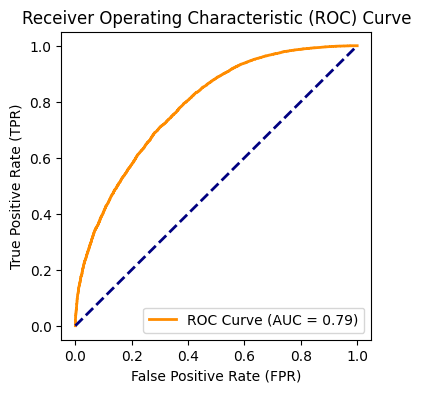

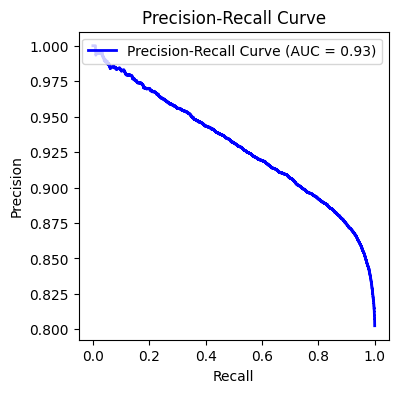

In [14]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities on the test set
y_proba = random_search.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(4, 4))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

* Trade-off Analysis
1. The proportion of approved loans that are genuinely repaid, for such scenario we are getting good accuracy and have a good go ahead signal.
2. The proportion of actual repaid loans that are correctly identified, here we are lacking a bit and should focus on generating more such kind of data.

* Recommendations
1. It seems that we our Precision is good with 85% accuracy and we can take advantage of this and can generate more revenue as the loans approved are likely to be repaid.
2. We should focus more on generating Charged Off data, so that we improve our accuracy in that segment.
3. Our Recall is not that good as of now, so we may miss few opportunity but it will not hamper our bussiness.

* Feedback Loop
1. Monitoring Metrics: Set up a system to continuously monitor key performance metrics of your model, such as accuracy, precision, recall, F1 score, and area under the ROC curve (AUC-ROC). These metrics can give you insights into how well your model is performing.
2. Retraining Schedule: Establish a regular retraining schedule to update the model with new data. This could be daily, weekly, or based on the volume of incoming data. A scheduled retraining ensures that the model stays relevant and adapts to changing patterns in the data.
3. A/B Testing: Implement A/B testing to compare the performance of the existing model with that of a new model or an updated version. This allows you to assess the impact of changes before deploying them to production.
4. Collaboration with Stakeholders: Collaborate closely with domain experts, business stakeholders, and end-users. Their insights can help refine the model based on changing business needs or evolving requirements.
5. Feedback Loops: Set up feedback loops to collect user feedback on predictions. User feedback can provide valuable insights into model performance and help identify potential issues or areas for improvement.